In [1]:
import cobra
#from cobra import Model, Reaction, Metabolite
import pandas as pd
import cplex
import optlang
import math
import json
import sys
import cProfile
from optlang.symbolics import Zero, add
import cobra.util.solver as sutil
from cobra.flux_analysis.parsimonious import pfba
from IPython.core.display import HTML
import cobrakbase
sys.path.append("/Users/chandhanavoleti/Documents/SULI/ModelSEEDpy/ModelSEEDpy")
#import modelseedpy.fbapkg
from modelseedpy import ElementUptakePkg, SimpleThermoPkg, ReactionUsePkg, BilevelPkg, CommKineticPkg, KBaseMediaPkg

from collections import Counter
import numpy as np
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

kbase_api = cobrakbase.KBaseAPI()

cobrakbase 0.2.7


In [2]:
# for rxn in model.reactions
#     print(rxn.id)
#     parse reaction ID to get species
#     species = ?
#     for metabolite in rxn.metabolites
#          if metabolite.compartment == "e0"
#               metabolite_uptake[species][metabolite.id]["flux"] += rxn.metabolites[metabolite] x rxn.value
# look for metabolties that are consumed by one species and produced by another
# ex. 1 produced glucose and 2,3,4 consumed glucose
# store in a graph object where the nodes are species
# interactions[1][2] = flux (the least of the production 1 or consumption 2)
# interactions[1][3] = flux
# interactions[1][4] = flux
# visualize

# constraints
# solution
# visualize

In [3]:
def communityFBA(modelInfo,mediaInfo,kinetic_coeff,abundances=None):

    kbase_api = cobrakbase.KBaseAPI()
    #model = kbase_api.get_from_ws("CMM_iAH991V2_iML1515.kb",40576)
    model = kbase_api.get_from_ws(modelInfo[0],modelInfo[1])
    model.solver = 'optlang-cplex'

    #Applying uptake limit to total carbon uptake by model
    eup = ElementUptakePkg(model)
    eup.build_package({"C":60})
    #Applying constraints based on KBase media
    #media = kbase_api.get_from_ws("Btheta_Ecoli_minimal_media",40576)
    media = kbase_api.get_from_ws(mediaInfo[0],mediaInfo[1])
    kmp = KBaseMediaPkg(model)
    kmp.build_package(media)
    #Applying community model kinetic constraints
    ckp = CommKineticPkg(model)
    ckp.build_package(kinetic_coeff,abundances) # <- SPECIES ABUNDANCE BUG?

    biomass_objective = model.problem.Objective(
        1 * model.reactions.bio1.flux_expression,
        direction='max')
    model.objective = biomass_objective

    #sol=model.optimize()
    
    # pFBA
    sol = cobra.flux_analysis.pfba(model)
    
    #model.summary()
    
    # ---------------------------------------------------------------------------
    
    # metabolite in reactants: -stoich, -flux, uptake/production
    # metabolite in products: +stoich, +flux, secretion/consumption/export
    # donor species produces the metabolite

    metabolite_uptake = {}
    speciesNum = []
    for rxn in model.reactions:
        # obtain species
        ind = rxn.id.rfind('_')
        if (rxn.id[ind + 1] == 'c' or rxn.id[ind + 1] == 'p') and rxn.id[ind + 2: ] != '0':
            species = rxn.id[ind + 2: ]
            speciesNum.append(species)

            for metabolite in rxn.metabolites:
                if metabolite.compartment == "e0":
                    rate = 0
                    flux = sol.fluxes[rxn.id]
                    if flux != 0:
                        rate += rxn.metabolites[metabolite]*flux
                    if rate != 0:
                        metabolite_uptake[(metabolite.id,species)] = rate

    speciesNum = np.unique(speciesNum)
    numOfSpecies = len(speciesNum)
    
    # (('1', 'cpd00244_e0'), -2.806066380683855e-05)
    # for i in metabolite_uptake.items():
    #     print(i[0][0])
    # print(metabolite_uptake['cpd00244_e0'][0])
    # print('len of metabolite_uptake', len(metabolite_uptake))
    # rxn 34dhpactex_p1 metabolite cpd02500_e0

    external_metabolites = []
    for rxn in model.reactions:
        for metabolite in rxn.metabolites:
            if metabolite.compartment == "e0":
                external_metabolites.append(metabolite.id)

    cross_all = []
    for metabolite in external_metabolites:
        r_out = {x: r for (m, x), r in metabolite_uptake.items() if m == metabolite and r > 0}
        r_in = {x: -r for (m, x), r in metabolite_uptake.items() if m == metabolite and -r > 0}
        total_in = sum(r_in.values())
        total_out = sum(r_out.values())
        total = max(total_in, total_out)
        if total_in > total_out:
            r_out[None] = total_in - total_out
        if total_out > total_in:
            r_in[None] = total_out - total_in

        cross = [(o1, o2, metabolite, r1 * r2 / total) for o1, r1 in r_out.items() for o2, r2 in r_in.items()]
        cross_all.extend(cross) # [donor, receiver, compound, rate]

    # for i in cross_all:
    #     print(i)

    production = [[0] * numOfSpecies for i in range(numOfSpecies)] #production[donorSpecies][receiverSpecies]
    consumption = [[0] * numOfSpecies for i in range(numOfSpecies)]

    for i in cross_all:
        if i[0] is not None and i[1] is not None:
            production[int(i[0])-1][int(i[1])-1] += i[3]
            consumption[int(i[1])-1][int(i[0])-1] += i[3]

    # for i in production:
    #     print(i)
    # print(' ')
    # for i in consumption:
    #     print(i)

    G=nx.Graph()
    for i in speciesNum:
        G.add_node(i)
    for k in combinations(speciesNum, 2):
        sp1 = int(k[0])-1
        sp2 = int(k[1])-1
        if production[sp1][sp2] > consumption[sp2][sp1]:
            interaction_flux = production[sp1][sp2]
        else:
            interaction_flux = consumption[sp2][sp1]
        G.add_edge(k[0],k[1],weight=interaction_flux)

    pos=nx.planar_layout(G)
    nx.draw_networkx(G,pos)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

# 2 member community model

/Users/chandhanavoleti/opt/anaconda3/lib/python3.8/site-packages/cobra/core/metabolite.py:85 UserWarning: invalid character '*' found in formula '*'
/Users/chandhanavoleti/opt/anaconda3/lib/python3.8/site-packages/cobra/core/metabolite.py:85 UserWarning: invalid character '*' found in formula 'C12H20O10*2'


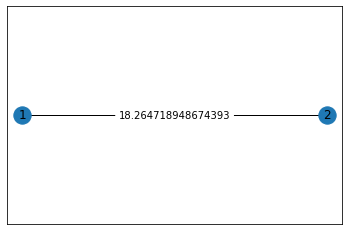

In [4]:
modelInfo_2 = ["CMM_iAH991V2_iML1515.kb",40576]
mediaInfo_2 = ["Btheta_Ecoli_minimal_media",40576]
communityFBA(modelInfo_2,mediaInfo_2,2100,{"1":0.5,"2":0.5})

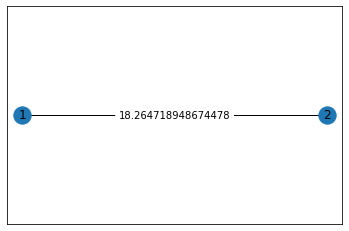

In [13]:
# Increasing the kinetic coefficient
communityFBA(modelInfo_2,mediaInfo_2,3000,{"1":0.5,"2":0.5})

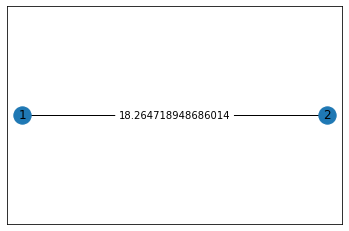

In [6]:
# Decreasing the kinetic coefficient
communityFBA(modelInfo_2,mediaInfo_2,2000,{"1":0.5,"2":0.5})

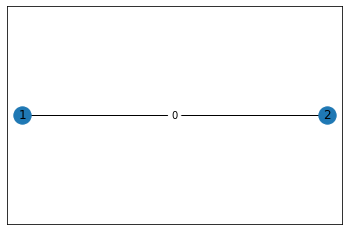

In [7]:
# Decreasing the kinetic coefficient so there is no biomass produced
communityFBA(modelInfo_2,mediaInfo_2,1000,{"1":0.5,"2":0.5})

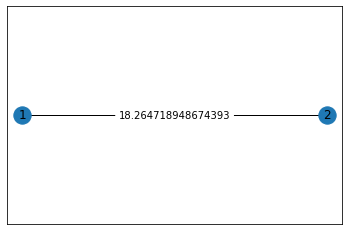

In [8]:
# SPECIES ABUNDANCE BUG?

# Changing the species abundances
communityFBA(modelInfo_2,mediaInfo_2,2100,{"1":0.1,"2":0.9})
# No change in interaction flux

# 3 member community model

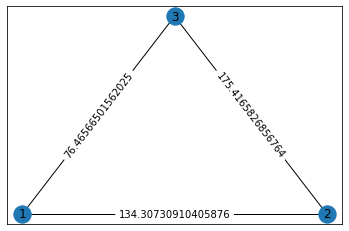

In [9]:
modelInfo_3 = ["electrosynth_comnty.mdl.gf.2021",93204]
mediaInfo_3 = ["CO2_minimal",93204]
communityFBA(modelInfo_3,mediaInfo_3,2100,{"1":0.3,"2":0.3,"3":0.4})

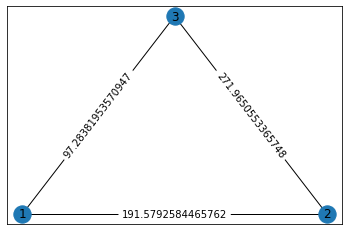

In [14]:
# Increasing the kinetic coefficient
communityFBA(modelInfo_3,mediaInfo_3,2500,{"1":0.1,"2":0.1,"3":0.8})

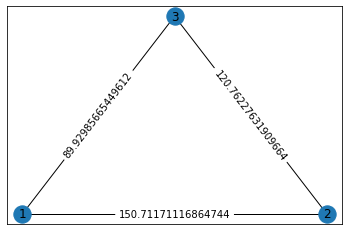

In [11]:
# Decreasing the kinetic coefficient
communityFBA(modelInfo_3,mediaInfo_3,2700)

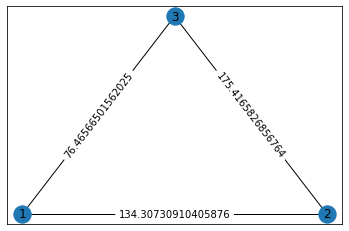

In [12]:
# SPECIES ABUNDANCE BUG?

# Changing the species abundances
communityFBA(modelInfo_3,mediaInfo_3,2100,{"1":0.1,"2":0.1,"3":0.8})
# No change?